# DVH Analysis

This notebook demonstrates how to compute and plot a DVH (Dose Volume Histogram).

## Import Modules

In [1]:
try:
    import platipy
except:
    !pip install platipy
    import platipy

import matplotlib
import matplotlib.pyplot as plt
import SimpleITK as sitk

%matplotlib inline

from platipy.imaging.tests.data import get_hn_nifti
from platipy.imaging import ImageVisualiser
from platipy.imaging.label.utils import get_com
from platipy.imaging.dose.dvh import calculate_dvh_for_labels, calculate_d_x, calculate_v_x
from platipy.imaging.visualisation.dose import visualise_dose

## Download Test Data

This will download some data from the TCIA TCGA-HNSC dataset. The data is for one patient and
contains a CT, dose and some structures.

In [2]:
data_path = get_hn_nifti()

## Load data

Let's read in the data that we've downloaded

In [3]:
test_pat_path = data_path.joinpath("TCGA_CV_5977")

ct_image = sitk.ReadImage(str(test_pat_path.joinpath("IMAGES/TCGA_CV_5977_1_CT_ONC_NECK_NECK_4.nii.gz")))

dose = sitk.ReadImage(str(test_pat_path.joinpath("DOSES/TCGA_CV_5977_1_PLAN.nii.gz")))

dose = sitk.Resample(dose, ct_image)

structure_names =["BRAINSTEM", "MANDIBLE", "CTV_60_GY", "PTV60", "CORD", "L_PAROTID", "R_PAROTID"]

structures = {
    s: sitk.ReadImage(str(test_pat_path.joinpath("STRUCTURES", f"TCGA_CV_5977_1_RTSTRUCT_{s}.nii.gz"))) for s in structure_names
}

## Visualise data

and now let's visualise the data we've got

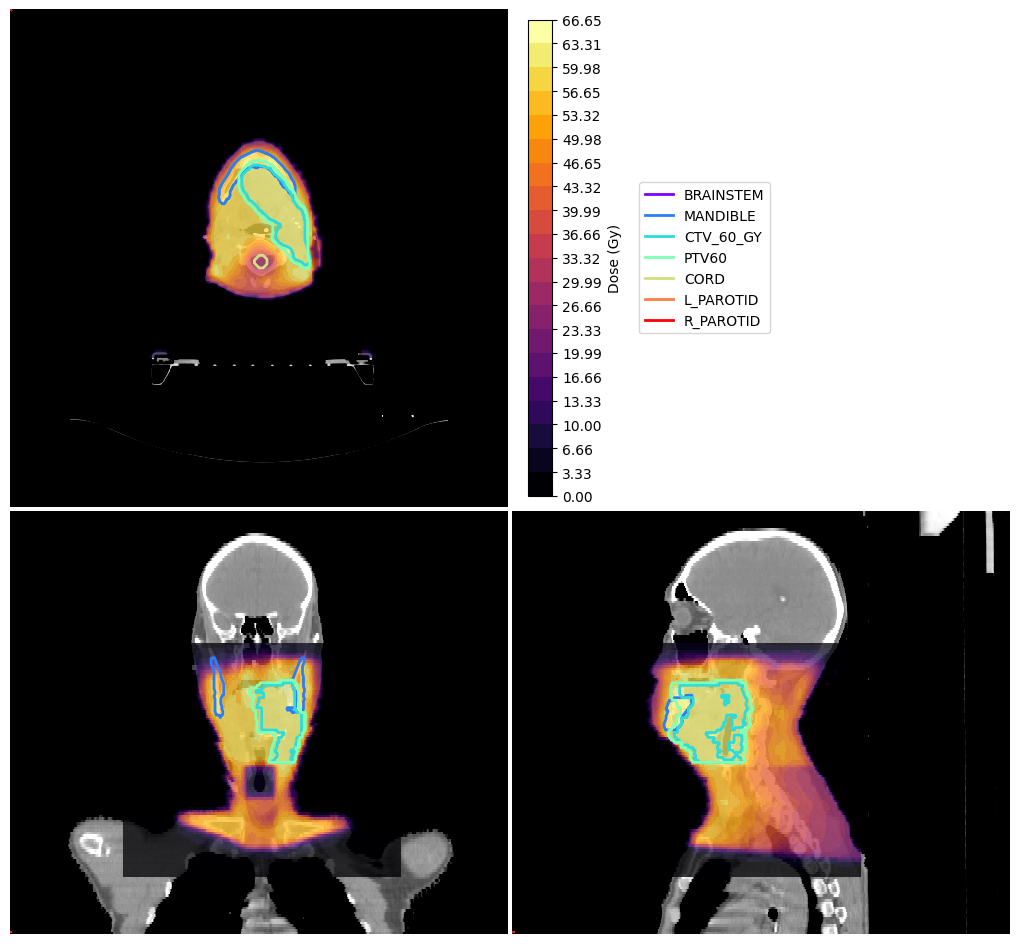

In [4]:
vis = ImageVisualiser(ct_image, cut=get_com(structures["PTV60"]))

vis.add_scalar_overlay(dose, discrete_levels=20, colormap=matplotlib.colormaps.get_cmap("inferno"), name="Dose (Gy)")
vis.add_contour(structures)

fig = vis.show()

## Compute DVH

here we compute the DVH using the dose and structures loaded. We get the DVH back in a pandas
DataFrame object.

In [5]:
dvh = calculate_dvh_for_labels(dose, structures)

In [6]:
dvh

,label,cc,mean,0.0,0.1,0.2,0.3,0.4,0.5,0.6,...,65.7,65.8,65.9,66.0,66.1,66.2,66.3,66.4,66.5,66.6
0,BRAINSTEM,11.885166,9.360401,1.0,0.857974,0.857974,0.857974,0.857974,0.857974,0.857974,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,MANDIBLE,62.763691,54.402473,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000418,0.000342,0.000266,0.000228,0.000152,0.000076,0.000076,0.000038,0.000038,0.000000
2,CTV_60_GY,190.980434,61.534935,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000300,0.000250,0.000162,0.000125,0.000112,0.000062,0.000037,0.000025,0.000012,0.000000
3,PTV60,280.199051,61.134624,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000332,0.000281,0.000221,0.000179,0.000145,0.000085,0.000068,0.000051,0.000034,0.000017
4,CORD,24.590492,26.596514,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,L_PAROTID,7.548332,22.993076,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,R_PAROTID,12.702942,21.784250,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Plot DVH

using the pandas DataFrame, we plot the DVH here. The DVH first needs to be reshaped to prepare it for plotting.

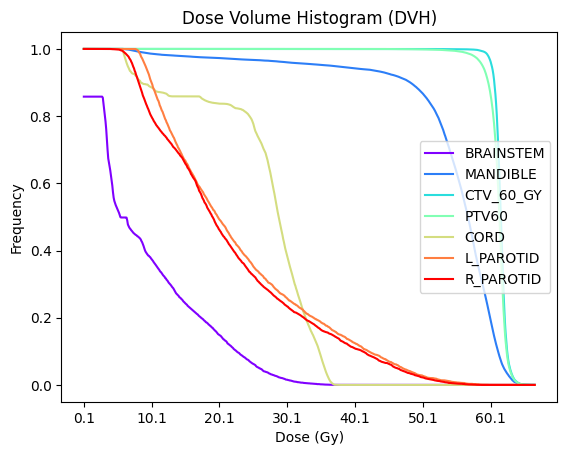

In [7]:
# Reshape the DVH
plt_dvh = dvh
plt_dvh = plt_dvh.set_index("label")
plt_dvh = plt_dvh.iloc[:,3:].transpose()

# Plot the DVH
fig, ax = plt.subplots()
plt_dvh.plot(ax=ax, kind="line", colormap=matplotlib.colormaps.get_cmap("rainbow"), legend=False)

# Add labels and show plot
plt.legend(loc='best')
plt.xlabel("Dose (Gy)")
plt.ylabel("Frequency")
plt.title("Dose Volume Histogram (DVH)")
plt.show()

## DVH Metrics

Finally, we extract commonly used metrics from the DVH. In the following cells we extract the D0 and D95 as well as the V5 and V20.

In [8]:
df_metrics_d = calculate_d_x(dvh, [0, 95])
df_metrics_d

,label,D0,D95
0,BRAINSTEM,37.1,0.035205
1,MANDIBLE,66.6,36.565625
2,CTV_60_GY,66.6,60.255060
3,PTV60,66.6,58.903234
4,CORD,37.7,6.558704
5,L_PAROTID,60.2,9.182000
6,R_PAROTID,58.7,7.333571


In [9]:
df_metrics_v = calculate_v_x(dvh, [5, 20])
df_metrics_v

,label,V5,V20
0,BRAINSTEM,6.253719,1.780987
1,MANDIBLE,62.763691,61.063766
2,CTV_60_GY,190.980434,190.980434
3,PTV60,280.199051,280.199051
4,CORD,24.590492,20.592213
5,L_PAROTID,7.548332,3.736019
6,R_PAROTID,12.681484,5.893707


## Dose and DVH visualisation

The `visualise_dose` function can produce a visualisation including the DVH and dose metrics.

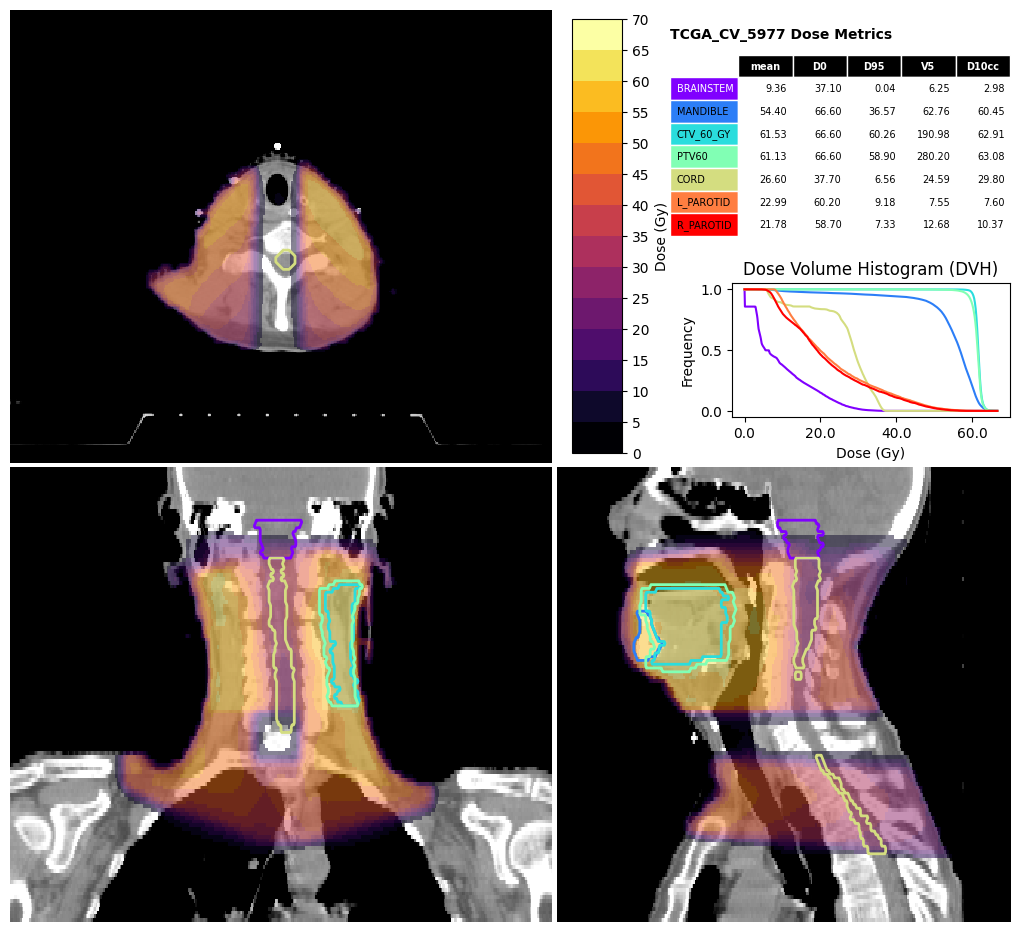

In [10]:
fig, df_metrics = visualise_dose(
    ct_image,
    dose,
    structures,
    dvh=dvh,
    d_points=[0, 95],
    v_points=[5],
    d_cc_points=[10],
    structure_for_limits=dose>5,
    expansion_for_limits=40,
    contour_cmap=matplotlib.colormaps.get_cmap("rainbow"),
    dose_cmap=matplotlib.colormaps.get_cmap("inferno"),
    title="TCGA_CV_5977 Dose Metrics")